<a href="https://colab.research.google.com/github/khushijashnani/CEEL-82B---Data-Science/blob/master/Exp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Data Science - Experiment 6**

Name - Khushi Jashnani

UID - 2018130017

###**Objective**: 
To perform time series analysis: identifying the nature of the phenomenon represented by the sequence of observations, and forecasting



In [1]:
# importing the necessary libraries

import seaborn as sns
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline  
import statsmodels
import statsmodels.api as sm             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Connecting/Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Colab Notebooks/DS/Labs/Exp6

/content/drive/MyDrive/Colab Notebooks/DS/Labs/Exp6


### **1. Load the dataset (Use pandas )**

In [4]:
# Reading the training dataset
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


**Analysis:** It's a time series dependent case wherein there is an increasing trend for time component

### **2. Exploratory Data Analysis of the dataset**

In [6]:
# Checking the shape of the dataset
data.shape

(144, 2)

In [7]:
# Check for null values
data.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [8]:
# Checking the information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
data.describe()  

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [10]:
#Parse strings to datetime type
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = data.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


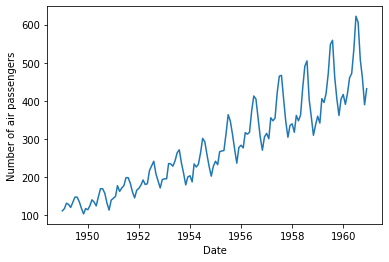

In [11]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

**Analysis** :

Here we can observe that the dataset has a particular trend and seasonality for a fixed time period. 

We can see a particular pattern repeating every year.

Now let's check if our data is stationarity

### **Decomposition of a Time Series**


Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.

The seasonal_decompose in statsmodels implements this conveniently.

In [12]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

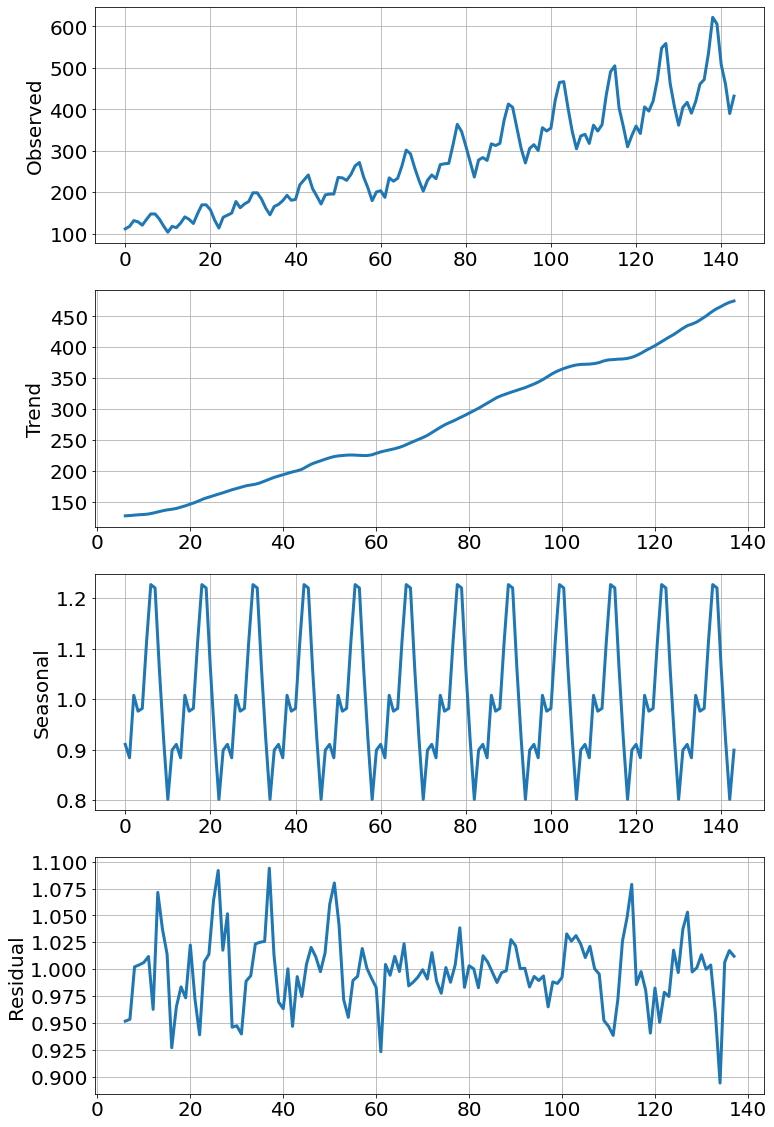

In [13]:
mult_decomposition = seasonal_decompose(data['#Passengers'], freq=12, model='multiplicative') 
plot_decompose(mult_decomposition)

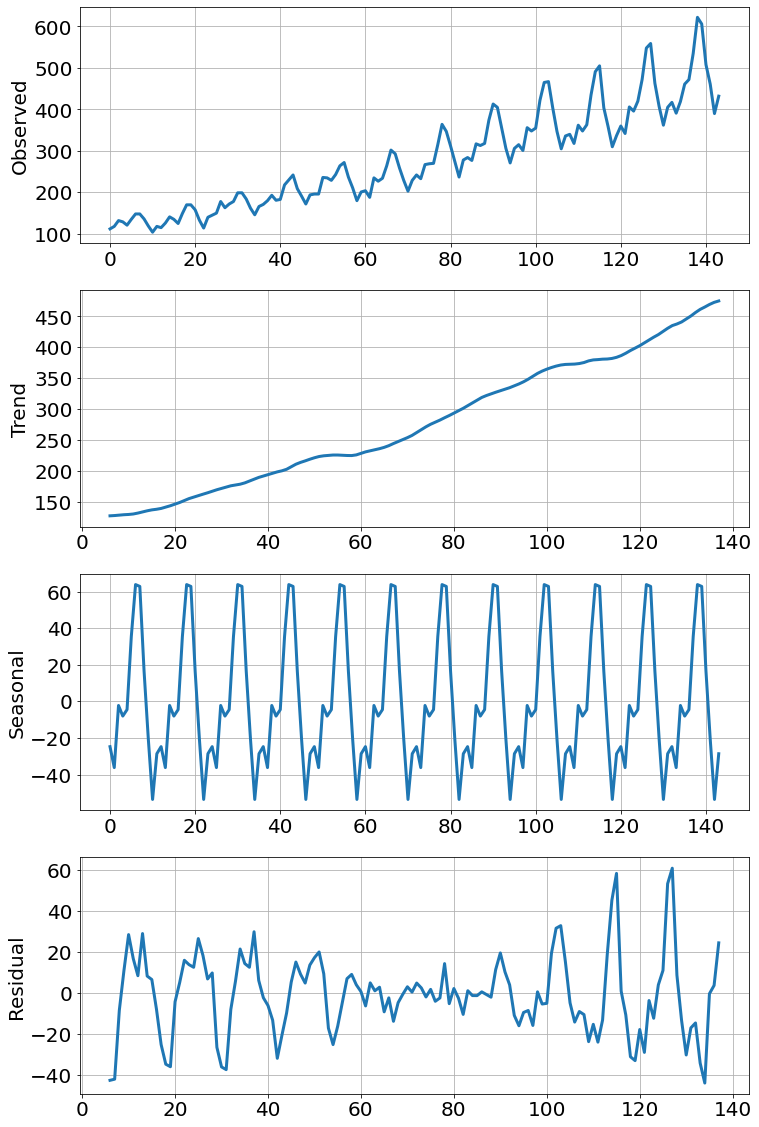

In [14]:
add_decomposition = seasonal_decompose(data['#Passengers'], freq=12, model='additive') 
plot_decompose(add_decomposition)

**Analysis:** 
1. As we can see there is a seasonal periodicity. 
2. We can see that the number of customers is gradually increasing from the trend line.
3. Also, the additive model has some periodicity left while the multiplicative decomposition looks random, hence we should consider that

### **Stationarity Property**

Stationarity is a property of a time series where the values of the series is not a function of time. So, the values are independent of time.

Hence the statistical properties of the series like mean, variance and autocorrelation are constant over time. 

Autocorrelation of the series is nothing but the correlation of the series with its previous values.

A stationary time series is independent of seasonal effects as well.

### **How to check Stationarity ?**
The stationarity of a series can be checked by 

1. Looking at the plot of the series.

2. Augmented Dickey Fuller test (ADF Test)

3. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

4. Philips Perron test (PP Test)

#### 1. Looking at the rolling statics plots

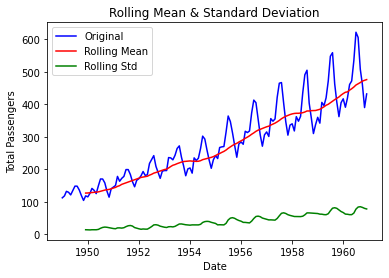

In [15]:
def rolling_stats(series):
    #Determine rolling statistics
    rolmean = series.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level

    rolstd = series.rolling(window=12).std()

    #Plot rolling statistics
    orig = plt.plot(series, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel('Total Passengers')
    plt.xlabel('Date')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

rolling_stats(indexedDataset["#Passengers"])

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. 

Since it has a trend, we may conclude that it is non-stationary time series data.

But let's confirm it with the ADF Test



#### 2. Augmented Dickey Fuller test (ADF Test)

Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

In [16]:
# Stability Test (Dickey-Fuller Test)
def adfTest(y):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

adfTest(indexedDataset["#Passengers"])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Now here since the p value is more than 0.05 and there is a significant difference between the test statistic value and critical values. 

We can accept the null hypothesis and conclude that the time series is a non-stationary one.

In [17]:
def is_stationary(series):
    rolling_stats(series)
    adfTest(series)

#### Autocorrelation and Partial Autocorrelation Functions

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

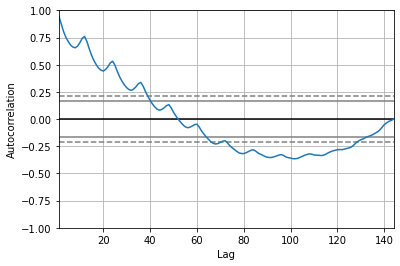

In [18]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(indexedDataset['#Passengers'].tolist())

In [19]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(indexedDataset['#Passengers'], nlags=10)
lag_pacf = pacf(indexedDataset['#Passengers'], nlags=10, method='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


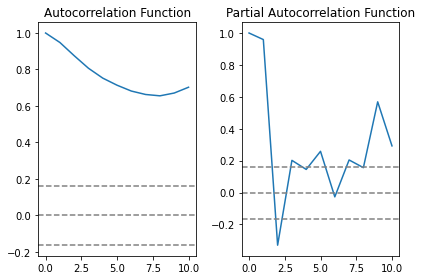

In [20]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(indexedDataset['#Passengers'])), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(indexedDataset['#Passengers'])), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(indexedDataset['#Passengers'])), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(indexedDataset['#Passengers'])), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

###**White noise: Differentiating signal from the noise.**

Like a stationary series, the white noise is also not a function of time. So, its mean and variance does not change over time. But the difference is that, the white noise is completely random with a mean of 0. In white noise there is no pattern.

But since our time series doesn't have a mean of 0 and does have a pattern/seasonality to it, we can differentiate it from white noise.

### **Converting the non-stationary series into a stationary series**

Mostly statistical forecasting methods are designed to work on a stationary time series. 

Thus, the first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

So for our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. 

We can apply some sort of transformation to make the time-series stationary. These transformation may include:

- Differencing the Series (once or more)
- Take the log of the series
- Take the nth root of the series
- Combination of the above

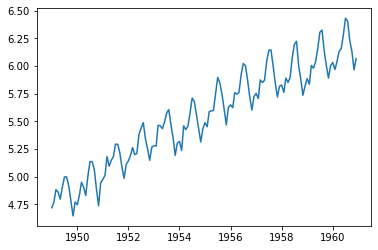

In [21]:
ts_log = np.log(indexedDataset['#Passengers'])
plt.plot(ts_log)

1. DeTrend by differencing with the moving average

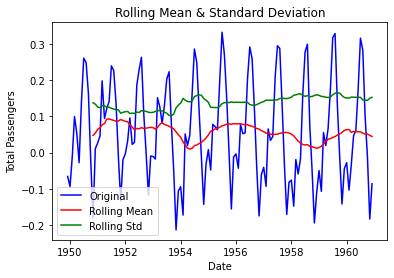

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [22]:
detrended = ts_log - ts_log.rolling(12).mean()
detrended.dropna(inplace=True)
is_stationary(detrended)

2. DeTrend by differencing with the weighted moving average 

(eg. exponential weighted moving averaged, majorly used in complex situations where weights are assigned to all the previous values with a decay factor)

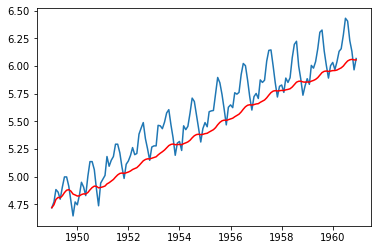

In [23]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

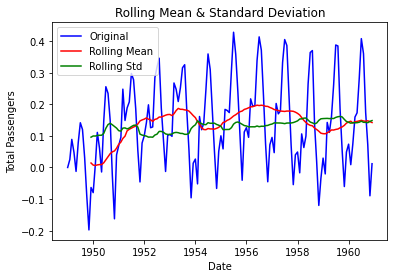

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [24]:
detrended_ewm = ts_log - exp_weighted_avg
detrended_ewm.dropna(inplace=True)
is_stationary(detrended_ewm)

2. Deseasonalize

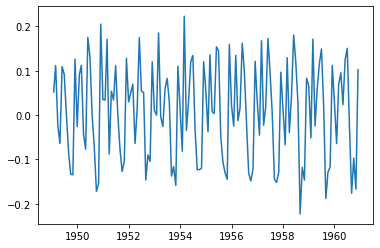

In [25]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

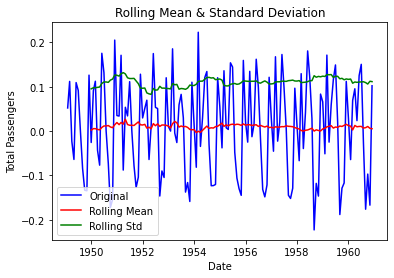

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [26]:
ts_log_diff.dropna(inplace = True)
is_stationary(ts_log_diff)

### Splitting the dataset into train and test sets

In [27]:
train = indexedDataset[:108]
test = indexedDataset[108:]

In [28]:
def plot_prediction(y_pred, label):
    train["#Passengers"].plot(legend=True, label="TRAIN")
    test["#Passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train and Test Using "+label)
    plt.show()

**Single Exponential Smoothing** is time series forecasting method for univariate data without a trend or seasonality. It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

alpha: 0.01 mae: 185.338
alpha: 0.11 mae: 80.2736
alpha: 0.21 mae: 76.3424
alpha: 0.31 mae: 79.9889
alpha: 0.41 mae: 85.8349
alpha: 0.51 mae: 91.4969
alpha: 0.61 mae: 95.9495
alpha: 0.71 mae: 98.2011
alpha: 0.81 mae: 98.4145
alpha: 0.91 mae: 97.0815
best_alpha: 0.21 best_mae: 76.3424


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

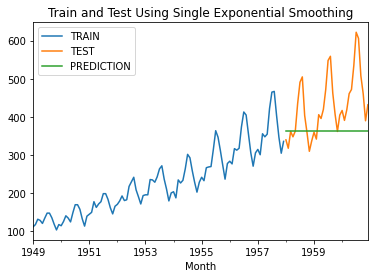

In [29]:
# Single Exponential Smoothing 

def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=36)

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(36)

plot_prediction(y_pred, "Single Exponential Smoothing")

Here we can see that due to a single coefficient alpha, it could capture only the level of the predicted values i.e a straight line showing no trend or seasonality.

**Double exponential smoothing** is a time series forecasting method which employs a **level component** and a **trend component** at each period. It uses two weights, (alpha and beta) (also called smoothing parameters), to update the components at each period.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

alpha: 0.01 beta: 0.01 mae: 53.2755
alpha: 0.01 beta: 0.11 mae: 91.943
alpha: 0.01 beta: 0.21 mae: 55.2045
alpha: 0.01 beta: 0.31 mae: 77.1112
alpha: 0.01 beta: 0.41 mae: 100.3906
alpha: 0.01 beta: 0.51 mae: 92.456
alpha: 0.01 beta: 0.61 mae: 72.0436
alpha: 0.01 beta: 0.71 mae: 60.1845
alpha: 0.01 beta: 0.81 mae: 56.6097
alpha: 0.01 beta: 0.91 mae: 59.1563
alpha: 0.11 beta: 0.01 mae: 54.5297
alpha: 0.11 beta: 0.11 mae: 61.181
alpha: 0.11 beta: 0.21 mae: 56.632
alpha: 0.11 beta: 0.31 mae: 56.5443
alpha: 0.11 beta: 0.41 mae: 58.1405
alpha: 0.11 beta: 0.51 mae: 58.8955
alpha: 0.11 beta: 0.61 mae: 59.5667
alpha: 0.11 beta: 0.71 mae: 66.5189
alpha: 0.11 beta: 0.81 mae: 78.4869
alpha: 0.11 beta: 0.91 mae: 96.3861
alpha: 0.21 beta: 0.01 mae: 53.9942
alpha: 0.21 beta: 0.11 mae: 55.0963
alpha: 0.21 beta: 0.21 mae: 66.068
alpha: 0.21 beta: 0.31 mae: 95.5315
alpha: 0.21 beta: 0.41 mae: 147.897
alpha: 0.21 beta: 0.51 mae: 229.1414
alpha: 0.21 beta: 0.61 mae: 345.2926
alpha: 0.21 beta: 0.71 mae: 50

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

0.31 mae: 236.7046
alpha: 0.31 beta: 0.41 mae: 383.7124
alpha: 0.31 beta: 0.51 mae: 570.9737
alpha: 0.31 beta: 0.61 mae: 784.5235
alpha: 0.31 beta: 0.71 mae: 989.7878
alpha: 0.31 beta: 0.81 mae: 1148.738
alpha: 0.31 beta: 0.91 mae: 1239.9963
alpha: 0.41 beta: 0.01 mae: 55.5231
alpha: 0.41 beta: 0.11 mae: 103.0115
alpha: 0.41 beta: 0.21 mae: 215.884
alpha: 0.41 beta: 0.31 mae: 370.6355
alpha: 0.41 beta: 0.41 mae: 556.0086
alpha: 0.41 beta: 0.51 mae: 740.7093
alpha: 0.41 beta: 0.61 mae: 888.7384
alpha: 0.41 beta: 0.71 mae: 978.3415
alpha: 0.41 beta: 0.81 mae: 1010.5216
alpha: 0.41 beta: 0.91 mae: 999.7536
alpha: 0.51 beta: 0.01 mae: 60.1467
alpha: 0.51 beta: 0.11 mae: 134.1659
alpha: 0.51 beta: 0.21 mae: 272.9764
alpha: 0.51 beta: 0.31 mae: 439.4408
alpha: 0.51 beta: 0.41 mae: 602.6586
alpha: 0.51 beta: 0.51 mae: 727.9415
alpha: 0.51 beta: 0.61 mae: 796.0875
alpha: 0.51 beta: 0.71 mae: 808.1434
alpha: 0.51 beta: 0.81 mae: 775.182
alpha: 0.51 beta: 0.91 mae: 707.7106
alpha: 0.61 beta: 0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

alpha: 0.61 beta: 0.71 mae: 592.805
alpha: 0.61 beta: 0.81 mae: 503.7382
alpha: 0.61 beta: 0.91 mae: 380.7632
alpha: 0.71 beta: 0.01 mae: 66.2102
alpha: 0.71 beta: 0.11 mae: 160.8952
alpha: 0.71 beta: 0.21 mae: 296.7006
alpha: 0.71 beta: 0.31 mae: 418.6832
alpha: 0.71 beta: 0.41 mae: 494.3961
alpha: 0.71 beta: 0.51 mae: 508.8246
alpha: 0.71 beta: 0.61 mae: 464.6078
alpha: 0.71 beta: 0.71 mae: 372.4994
alpha: 0.71 beta: 0.81 mae: 244.6438
alpha: 0.71 beta: 0.91 mae: 93.6347
alpha: 0.81 beta: 0.01 mae: 66.6531
alpha: 0.81 beta: 0.11 mae: 158.6886
alpha: 0.81 beta: 0.21 mae: 278.7299


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

alpha: 0.81 beta: 0.31 mae: 369.9914
alpha: 0.81 beta: 0.41 mae: 405.9117
alpha: 0.81 beta: 0.51 mae: 379.9796
alpha: 0.81 beta: 0.61 mae: 300.6856
alpha: 0.81 beta: 0.71 mae: 182.2917
alpha: 0.81 beta: 0.81 mae: 55.4524
alpha: 0.81 beta: 0.91 mae: 126.7683
alpha: 0.91 beta: 0.01 mae: 65.5569
alpha: 0.91 beta: 0.11 mae: 150.1581
alpha: 0.91 beta: 0.21 mae: 251.4921
alpha: 0.91 beta: 0.31 mae: 313.9495
alpha: 0.91 beta: 0.41 mae: 317.5281
alpha: 0.91 beta: 0.51 mae: 262.7694
alpha: 0.91 beta: 0.61 mae: 162.8169
alpha: 0.91 beta: 0.71 mae: 53.2635
alpha: 0.91 beta: 0.81 mae: 121.7339
alpha: 0.91 beta: 0.91 mae: 257.864
best_alpha: 0.91 best_beta: 0.71 best_mae: 53.2635


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

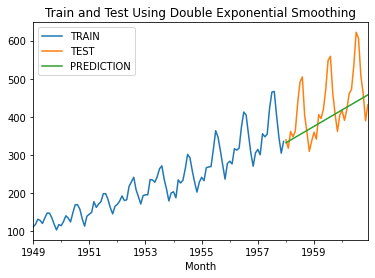

In [30]:
# Double Exponential Smoothing

def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=36)
#54.10

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(36)

plot_prediction(y_pred, "Double Exponential Smoothing")

Here we can see that due to two coefficients alpha and beta, it could capture the level as well as the trend of the time series and thus gave a slant line with a positive slope. Thus, the forecasted values show a level and a trend compnent in them.

**Triple exponential smoothing** is a forecasting method which is used to handle the time series data containing a seasonal component. This method is based on three smoothing equations: level, trend, and seasonality thus having three smoothing coefficients i.e alpha, beta and gamma.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

[0.1, 0.1, 0.1, 42.96]
[0.1, 0.1, 0.3, 36.14]
[0.1, 0.1, 0.5, 31.54]
[0.1, 0.1, 0.7, 29.14]
[0.1, 0.1, 0.9, 28.23]
[0.1, 0.3, 0.1, 39.31]
[0.1, 0.3, 0.3, 34.51]
[0.1, 0.3, 0.5, 34.56]
[0.1, 0.3, 0.7, 35.98]
[0.1, 0.3, 0.9, 38.39]
[0.1, 0.5, 0.1, 51.5]
[0.1, 0.5, 0.3, 47.56]
[0.1, 0.5, 0.5, 44.63]
[0.1, 0.5, 0.7, 54.23]
[0.1, 0.5, 0.9, 85.44]
[0.1, 0.7, 0.1, 47.03]
[0.1, 0.7, 0.3, 50.88]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

[0.1, 0.7, 0.5, 68.22]
[0.1, 0.7, 0.7, 113.84]
[0.1, 0.7, 0.9, 217.14]
[0.1, 0.9, 0.1, 50.43]
[0.1, 0.9, 0.3, 63.09]
[0.1, 0.9, 0.5, 63.77]
[0.1, 0.9, 0.7, 40.02]
[0.1, 0.9, 0.9, 169.24]
[0.3, 0.1, 0.1, 33.58]
[0.3, 0.1, 0.3, 31.75]
[0.3, 0.1, 0.5, 30.14]
[0.3, 0.1, 0.7, 27.1]
[0.3, 0.1, 0.9, 25.41]
[0.3, 0.3, 0.1, 65.34]
[0.3, 0.3, 0.3, 30.08]
[0.3, 0.3, 0.5, 27.95]
[0.3, 0.3, 0.7, 30.36]
[0.3, 0.3, 0.9, 59.82]
[0.3, 0.5, 0.1, 241.16]
[0.3, 0.5, 0.3, 52.49]
[0.3, 0.5, 0.5, 140.03]
[0.3, 0.5, 0.7, 52.46]
[0.3, 0.5, 0.9, 502.42]
[0.3, 0.7, 0.1, 566.38]
[0.3, 0.7, 0.3, 65.0]
[0.3, 0.7, 0.5, 641.06]
[0.3, 0.7, 0.7, 1026.44]
[0.3, 0.7, 0.9, 785.08]
[0.3, 0.9, 0.1, 981.98]
[0.3, 0.9, 0.3, 612.95]
[0.3, 0.9, 0.5, 377.73]
[0.3, 0.9, 0.7, 1855.71]
[0.3, 0.9, 0.9, 3594.9]
[0.5, 0.1, 0.1, 47.08]
[0.5, 0.1, 0.3, 34.66]
[0.5, 0.1, 0.5, 31.13]
[0.5, 0.1, 0.7, 31.63]
[0.5, 0.1, 0.9, 25.52]
[0.5, 0.3, 0.1, 182.45]
[0.5, 0.3, 0.3, 132.62]
[0.5, 0.3, 0.5, 47.39]
[0.5, 0.3, 0.7, 177.52]
[0.5, 0.3, 0.9, 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

[0.5, 0.7, 0.5, 946.19]
[0.5, 0.7, 0.7, 644.66]
[0.5, 0.7, 0.9, 221.14]
[0.5, 0.9, 0.1, 849.24]
[0.5, 0.9, 0.3, 1175.32]
[0.5, 0.9, 0.5, 1562.07]
[0.5, 0.9, 0.7, 1792.99]
[0.5, 0.9, 0.9, 923.35]
[0.7, 0.1, 0.1, 64.42]
[0.7, 0.1, 0.3, 71.96]
[0.7, 0.1, 0.5, 41.57]
[0.7, 0.1, 0.7, 33.49]
[0.7, 0.1, 0.9, 50.85]
[0.7, 0.3, 0.1, 211.66]
[0.7, 0.3, 0.3, 328.72]
[0.7, 0.3, 0.5, 222.65]
[0.7, 0.3, 0.7, 85.29]
[0.7, 0.3, 0.9, 162.25]
[0.7, 0.5, 0.1, 307.98]
[0.7, 0.5, 0.3, 698.29]
[0.7, 0.5, 0.5, 720.57]
[0.7, 0.5, 0.7, 741.68]
[0.7, 0.5, 0.9, 670.84]
[0.7, 0.7, 0.1, 297.75]
[0.7, 0.7, 0.3, 882.33]
[0.7, 0.7, 0.5, 1003.04]
[0.7, 0.7, 0.7, 1413.43]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

[0.7, 0.7, 0.9, 2433.09]
[0.7, 0.9, 0.1, 489.17]
[0.7, 0.9, 0.3, 903.85]
[0.7, 0.9, 0.5, 757.07]
[0.7, 0.9, 0.7, 550.6]
[0.7, 0.9, 0.9, 1378.1]
[0.9, 0.1, 0.1, 123.46]
[0.9, 0.1, 0.3, 110.96]
[0.9, 0.1, 0.5, 76.15]
[0.9, 0.1, 0.7, 47.87]
[0.9, 0.1, 0.9, 37.61]
[0.9, 0.3, 0.1, 347.48]
[0.9, 0.3, 0.3, 410.86]
[0.9, 0.3, 0.5, 369.81]
[0.9, 0.3, 0.7, 301.76]
[0.9, 0.3, 0.9, 280.27]
[0.9, 0.5, 0.1, 439.55]
[0.9, 0.5, 0.3, 676.16]
[0.9, 0.5, 0.5, 703.96]
[0.9, 0.5, 0.7, 670.54]
[0.9, 0.5, 0.9, 1034.76]
[0.9, 0.7, 0.1, 352.42]
[0.9, 0.7, 0.3, 770.56]
[0.9, 0.7, 0.5, 857.9]
[0.9, 0.7, 0.7, 644.79]
[0.9, 0.7, 0.9, 1564.75]
[0.9, 0.9, 0.1, 159.95]
[0.9, 0.9, 0.3, 730.4]
[0.9, 0.9, 0.5, 1116.31]
[0.9, 0.9, 0.7, 1388.01]
[0.9, 0.9, 0.9, 6107.03]
best_alpha: 0.3 best_beta: 0.1 best_gamma: 0.9 best_mae: 25.4132


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

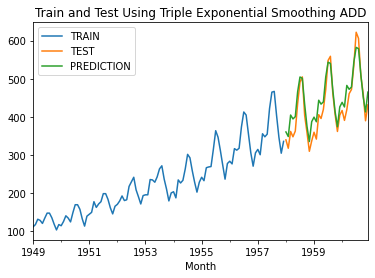

In [31]:
# Triple Exponential Smoothing (Holt-Winters)
import itertools

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=36)

tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(36)

plot_prediction(y_pred, "Triple Exponential Smoothing ADD")


Here we can see that the forecasted values are almost near to the actual values and thus we can see a reduction i.e descending trend in the MAE values from Single to Double to Triple Exponential Smoothing methods.

**ARIMA** is an autoregressive integrated moving average – ARIMA model is a generalization of a simple autoregressive moving average – ARMA model. Both of these models are used to forecast or predict future points in the time-series data. ARIMA is a form of regression analysis that indicates the strength of a dependent variable relative to other changing variables.

The final objective of the model is to predict future time series movement by examining the differences between values in the series instead of through actual values. ARIMA models are applied in the cases where the data shows evidence of non-stationarity.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(0, 0, 0) AIC=1270.55
ARIMA(0, 0, 1) AIC=1143.68
ARIMA(0, 1, 0) AIC=1002.83
ARIMA(0, 1, 1) AIC=991.65
ARIMA(0, 1, 2) AIC=989.10
ARIMA(0, 1, 3) AIC=978.09
ARIMA(0, 2, 0) AIC=1032.96
ARIMA(0, 2, 1) AIC=1001.15
ARIMA(0, 2, 2) AIC=989.39


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(0, 2, 3) AIC=987.49
ARIMA(1, 0, 0) AIC=1015.44
ARIMA(1, 0, 1) AIC=1002.26


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2) AIC=1001.83


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-pa

ARIMA(1, 0, 3) AIC=1011.45
ARIMA(1, 1, 0) AIC=996.37
ARIMA(1, 1, 1) AIC=994.46
ARIMA(1, 1, 2) AIC=971.49
ARIMA(1, 1, 3) AIC=973.49
ARIMA(1, 2, 0) AIC=1030.68
ARIMA(1, 2, 2) AIC=986.71


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(1, 2, 3) AIC=987.75
ARIMA(2, 0, 0) AIC=1006.85
ARIMA(2, 0, 1) AIC=1000.57


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmod

ARIMA(2, 0, 2) AIC=1024.84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.

ARIMA(2, 0, 3) AIC=1022.47
ARIMA(2, 1, 0) AIC=991.75
ARIMA(2, 1, 1) AIC=969.04
ARIMA(2, 1, 2) AIC=959.22
ARIMA(2, 1, 3) AIC=959.04


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0) AIC=1021.99
ARIMA(2, 2, 1) AIC=989.99
ARIMA(2, 2, 2) AIC=988.10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(2, 2, 3) AIC=989.70
ARIMA(3, 0, 0) AIC=1004.17
ARIMA(3, 0, 1) AIC=997.33


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-pa

ARIMA(3, 0, 2) AIC=985.64
ARIMA(3, 1, 0) AIC=992.65
ARIMA(3, 1, 1) AIC=970.85


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 2) AIC=966.63


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 3) AIC=952.53
ARIMA(3, 2, 0) AIC=1022.86
ARIMA(3, 2, 1) AIC=991.08


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(3, 2, 2) AIC=988.47
Best ARIMA(3, 1, 3) AIC=952.53
Best Params for ARIMA :  (3, 1, 3)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


MAE:  53.09206827937719


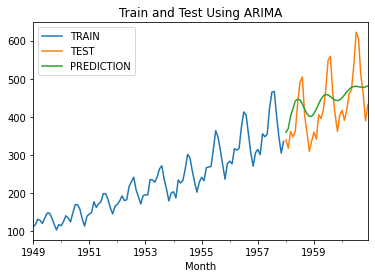

In [42]:
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params


best_params_aic = arima_optimizer_aic(train, pdq)

print("Best Params for ARIMA : ", best_params_aic)

# Tuned Model
arima_model = ARIMA(train, best_params_aic).fit(disp=0)

# Forecast
fc, se, conf = arima_model.forecast(36) 

fc_series = pd.Series(fc, index=test.index)

print("MAE: ",mean_absolute_error(test['#Passengers'], fc_series))

plot_prediction(pd.Series(fc_series, index=test.index), "ARIMA")

In [62]:
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  107
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -468.267
Method:                       css-mle   S.D. of innovations             18.818
Date:                Thu, 14 Apr 2022   AIC                            952.535
Time:                        15:34:51   BIC                            973.917
Sample:                    02-01-1949   HQIC                           961.203
                         - 12-01-1957                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.5143      0.725      3.467      0.001       1.093       3.936
ar.L1.D.#Passengers     0.9271      0.111      8.348      0.000       0.709       1.145
ar.L2.D.#Passeng

### **Conclusion -**

Through this experiment, I have performed time series analysis and forecasting on airline passenger dataset. 

I implemented several graphs for analysing the data whether it is stationary or not and then after it was confirmed that it was a non-stationary series, I tried to bring it to a stationary one through the various Detrend ad deseasonalisation methods. 

After that I used the state of the art models like smoothening and ARIMA models to forecast this time series data.